<a href="https://colab.research.google.com/github/MUHAMMADSHEHZAD01/Malaria_Detection_Model/blob/main/3_3_DBAIC(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Malaria Detection Using Convolutional Neural Networks (CNN)**
# Malaria Diagnosis/Malaria Detection (MDS)

## Installing Required Libraries

In [ ]:
!pip install tensorflow

    * os: Used for interacting with the operating system, including file handling (e.g., checking file existence, listing files in a directory).
    * cv2: OpenCV library used to handle images, such as reading and resizing images.
    * numpy: A powerful numerical computing library, mainly used for working with arrays. It’s used to handle image data as NumPy arrays.
    * PIL: The Python Imaging Library (Pillow) used for basic image processing tasks like resizing and converting between image formats.
    * itertools: Used for generating iterators, here specifically to iterate over indices for confusion matrix visualization.
    * matplotlib.pyplot: A popular plotting library used to generate graphs, including accuracy, loss, ROC curves, etc.
    * train_test_split: A function from sklearn.model_selection used to split the dataset into training and testing sets.
    * keras: The Keras deep learning API used to build and train the CNN model.
    * layers: Contains various layers (e.g., convolutional, pooling, dense) used to build the CNN architecture.
    * regularizers: (Not used in the code but can be imported to apply regularization to layers for preventing overfitting).

    EarlyStopping and ReduceLROnPlateau: Callbacks from Keras used to stop training early if the model's performance stops improving, and reduce the learning rate when the model's validation performance plateaus.

    * ImageDataGenerator: Used for real-time data augmentation during model training to artificially expand the dataset.
    * roc_curve, auc, precision_recall_curve, confusion_matrix ,classification_report: Evaluation metrics from sklearn used to analyze the model's performance.

In [ ]:
import os
import cv2
import numpy as np
from PIL import Image
import itertools
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras import layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix, classification_report

## Loading and Preprocessing Data

**Data Source:**  

    https://www.google.com/url?q=https%3A%2F%2Fdataverse.harvard.edu%2Fdataset.xhtml%3FpersistentId%3Ddoi%3A10.7910%2FDVN%2FO2WVWA

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define the path to the parent directory where the dataset is stored
dataset_path = '/content/drive/MyDrive/Datasets/dataverse_files'

# Load the dataset using TensorFlow's image_dataset_from_directory
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    label_mode='categorical',
    shuffle=True,
    color_mode='rgb',
    seed=123
)

# Check the class names (should be the names of your two subdirectories)
print("Class names:", dataset.class_names)

Found 2214 files belonging to 2 classes.
Class names: ['Thick_Infected', 'Thick_Uninfected']


In [ ]:
# List of subfolder names
subfolders = ['Thick_Uninfected', 'Thick_Infected']

# Define a function to count image files in each subfolder
def count_images_in_subfolder(subfolder_path):
    image_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff']  # Add more extensions as needed
    image_count = 0
    for filename in os.listdir(subfolder_path):
        if any(filename.lower().endswith(ext) for ext in image_extensions):
            image_count += 1
    return image_count

# Iterate over each subfolder and count images
for subfolder in subfolders:
    # Construct the subfolder path using the original dataset_path
    subfolder_path = os.path.join(dataset_path, subfolder)

    if os.path.exists(subfolder_path):
        image_count = count_images_in_subfolder(subfolder_path)
        print(f"Number of images in subfolder {subfolder}: {image_count}")
    else:
        print(f"Subfolder {subfolder} does not exist.")

Number of images in subfolder Thick_Uninfected: 1075
Number of images in subfolder Thick_Infected: 1139


In [ ]:
parasitized_images_path = "/content/drive/MyDrive/Datasets/dataverse_files/Thick_Infected"

for i, img_name in enumerate(os.listdir(parasitized_images_path)):
    if img_name.split(".")[1] == "png":
        img = cv2.imread(os.path.join(parasitized_images_path, img_name))
        img = Image.fromarray(img, "RGB")
        img = img.resize((256, 256))

In [ ]:
uninfected_images = "/content/drive/MyDrive/Datasets/dataverse_files/Thick_Uninfected"

for i, img_name in enumerate(os.listdir(uninfected_images)):
    if img_name.split(".")[1] == "png":
        img = cv2.imread(os.path.join(uninfected_images, img_name))
        img = Image.fromarray(img, "RGB")
        img = img.resize((256, 256))

## Data Normalization and Splitting

In [ ]:
# Iterate through the dataset and normalize images
normalized_images = []
normalized_labels = []

for images, labels in dataset:
    # Normalize pixel values to the range [0, 1]
    normalized_images.extend(images.numpy() / 255.0)
    normalized_labels.extend(labels.numpy())

# Convert the lists to NumPy arrays for easier handling
normalized_images = np.array(normalized_images)
normalized_labels = np.array(normalized_labels)

In [ ]:
# Now use normalized_images and normalized_labels in train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    normalized_images, normalized_labels, test_size=0.2, random_state=42
)

## Building the CNN Model


In [ ]:
from tensorflow.keras.regularizers import l2

model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(256, 256, 3)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.Flatten(),
    layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.01)),
    layers.BatchNormalization(),
    layers.Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(2, activation='softmax')  # 2 output neurons for binary classification # For classification with 2 classes
])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K

def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = K.epsilon()
        y_true = K.clip(y_true, epsilon, 1. - epsilon)
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * K.log(y_pred)
        loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy
        return K.sum(loss, axis=-1)
    return focal_loss_fixed

# model.compile(optimizer='adam', loss=focal_loss(), metrics=['accuracy'])


## Compiling the Model


In [ ]:
from tensorflow.keras.metrics import AUC, Precision, Recall

optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', AUC(), Precision(), Recall()])


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 256, 256, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 131072)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      67,109,376 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 128)                 │             5

 Total params: 67,371,586 (257.00 MB)

 Trainable params: 67,369,346 (256.99 MB)

 Non-trainable params: 2,240 (8.75 KB)

## Data Augmentation


In [ ]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train)

## Training the Model


In [ ]:
# Early stopping callback to stop when validation loss is not improving
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# Reduce learning rate when validation loss plateaus
# lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

In [ ]:
# Train the model
# Train the model with early stopping and degen data

batch_size = 32
epochs = 20

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs,
    validation_data=(X_test, y_test),  # Add validation data
    callbacks=[early_stopping, reduce_lr],  # Use callbacks
    verbose=1,
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


55/55 ━━━━━━━━━━━━━━━━━━━━ 67s 808ms/step - accuracy: 0.6959 - auc: 0.7586 - loss: 16.0091 - precision: 0.6959 - recall: 0.6959 - val_accuracy: 0.5011 - val_auc: 0.6430 - val_loss: 15.3214 - val_precision: 0.5011 - val_recall: 0.5011 - learning_rate: 1.0000e-04
Epoch 2/20
 1/55 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step - accuracy: 0.7188 - auc: 0.7969 - loss: 15.2820 - precision: 0.7188 - recall: 0.7188

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7188 - auc: 0.7969 - loss: 15.2820 - precision: 0.7188 - recall: 0.7188 - val_accuracy: 0.5011 - val_auc: 0.6427 - val_loss: 15.2979 - val_precision: 0.5011 - val_recall: 0.5011 - learning_rate: 1.0000e-04
Epoch 3/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.7746 - auc: 0.8524 - loss: 14.8095 - precision: 0.7746 - recall: 0.7746 - val_accuracy: 0.5011 - val_auc: 0.6374 - val_loss: 13.9422 - val_precision: 0.5011 - val_recall: 0.5011 - learning_rate: 1.0000e-04
Epoch 4/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8125 - auc: 0.8359 - loss: 13.8513 - precision: 0.8125 - recall: 0.8125 - val_accuracy: 0.5011 - val_auc: 0.6382 - val_loss: 13.9176 - val_precision: 0.5011 - val_recall: 0.5011 - learning_rate: 1.0000e-04
Epoch 5/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 28s 468ms/step - accuracy: 0.7919 - auc: 0.8607 - loss: 13.4082 - precision: 0.7919 - recall: 0.7919 - val_accuracy: 0.5011 - val_auc: 0.6521 - val_loss: 12.6

In [ ]:
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[AUC(), Precision(), Recall()])
'''batch_size = 32
epochs = 10

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs,
    validation_data=(X_test, y_test),  # Add validation data
    callbacks=[early_stopping, reduce_lr],  # Use callbacks
    verbose=1,
)'''

'batch_size = 32\nepochs = 10\n\nhistory = model.fit(\n    datagen.flow(X_train, y_train, batch_size=batch_size),\n    steps_per_epoch=len(X_train) // batch_size,\n    epochs=epochs,\n    validation_data=(X_test, y_test),  # Add validation data\n    callbacks=[early_stopping, reduce_lr],  # Use callbacks\n    verbose=1,\n)'

## Evaluating the Model


In [ ]:
# Evaluate the model
evaluation_results = model.evaluate(X_test, y_test, verbose=0)

In [ ]:
# Evaluate the model
evaluation_results = model.evaluate(X_test, y_test, verbose=0)
val_loss = evaluation_results[0] # Loss is the first element
val_accuracy = evaluation_results[1] # Accuracy (or AUC in your case) is the second element

# Access other metrics if needed:
val_auc = evaluation_results[1] # Assuming AUC is the first metric specified
val_precision = evaluation_results[2] # Assuming Precision is the second metric specified
val_recall = evaluation_results[3] # Assuming Recall is the third metric specified

# Get model predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels (0 or 1)
y_true_classes = np.argmax(y_test, axis=1)  # Convert one-hot encoded labels to class labels

# Calculate precision, recall, and AUC
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix, classification_report, precision_score, recall_score, roc_auc_score # Import roc_auc_score

val_precision = precision_score(y_true_classes, y_pred_classes)
val_recall = recall_score(y_true_classes, y_pred_classes)
val_auc = roc_auc_score(y_test, y_pred)  # Use y_pred (probabilities) for AUC

print(f"Validation Accuracy: {val_accuracy:.2f}")
print(f"Validation Loss: {val_loss:.2f}")
print(f"Validation Precision: {val_precision:.2f}")
print(f"Validation Recall: {val_recall:.2f}")
print(f"Validation AUC: {val_auc:.2f}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step
Validation Accuracy: 0.68
Validation Loss: 6.70
Validation Precision: 0.61
Validation Recall: 1.00
Validation AUC: 0.87


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


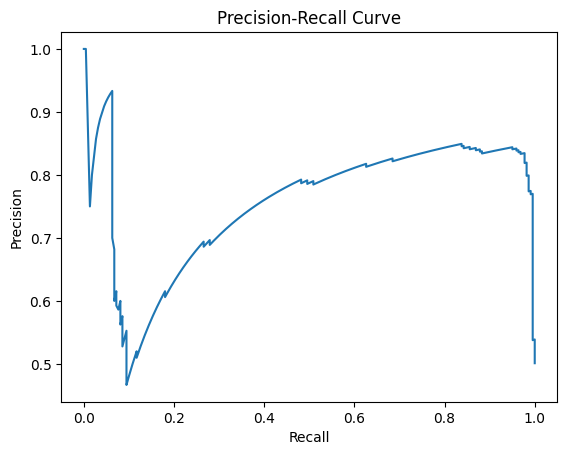

In [ ]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Get predictions probabilities
y_pred_prob = model.predict(X_test)

# Extract probabilities for the positive class (assuming class 1 is positive)
y_pred_probs = y_pred_prob[:, 1]

# Convert y_test to binary format (assuming class 1 is positive)
y_test_binary = y_test[:, 1]  # Select the column corresponding to the positive class

# Calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test_binary, y_pred_probs)

# Plot the curve
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# Find the optimal threshold for precision-recall trade-off
optimal_idx = np.argmax(precision + recall)  # or other optimization methods
optimal_threshold = thresholds[optimal_idx]

# Apply threshold
y_pred = (y_pred_prob >= optimal_threshold).astype(int)


In [ ]:
'''from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import numpy as np

kfold = StratifiedKFold(n_splits=5, shuffle=True)

# Convert y_train to a single-column array with class labels
y_train_labels = np.argmax(y_train, axis=1)

for train_idx, val_idx in kfold.split(X_train, y_train_labels):  # Use y_train_labels for splitting
    X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
    y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

    model.fit(X_train_fold, y_train_fold, epochs=30, batch_size=32)

    # Evaluate model
    y_pred_prob = model.predict(X_val_fold)
    auc = roc_auc_score(y_val_fold, y_pred_prob)
    print(f"AUC for fold: {auc}")'''

'from sklearn.model_selection import StratifiedKFold\nfrom sklearn.metrics import roc_auc_score\nimport numpy as np\n\nkfold = StratifiedKFold(n_splits=5, shuffle=True)\n\n# Convert y_train to a single-column array with class labels\ny_train_labels = np.argmax(y_train, axis=1)\n\nfor train_idx, val_idx in kfold.split(X_train, y_train_labels):  # Use y_train_labels for splitting\n    X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]\n    y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]\n\n    model.fit(X_train_fold, y_train_fold, epochs=30, batch_size=32)\n\n    # Evaluate model\n    y_pred_prob = model.predict(X_val_fold)\n    auc = roc_auc_score(y_val_fold, y_pred_prob)\n    print(f"AUC for fold: {auc}")'

## Visualization of Results


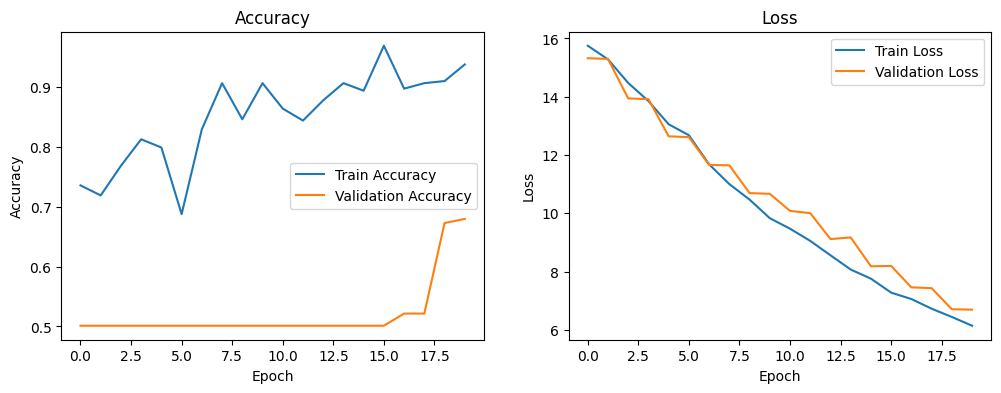

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show();



In [ ]:
y_pred_probs = model.predict(X_test).ravel()


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


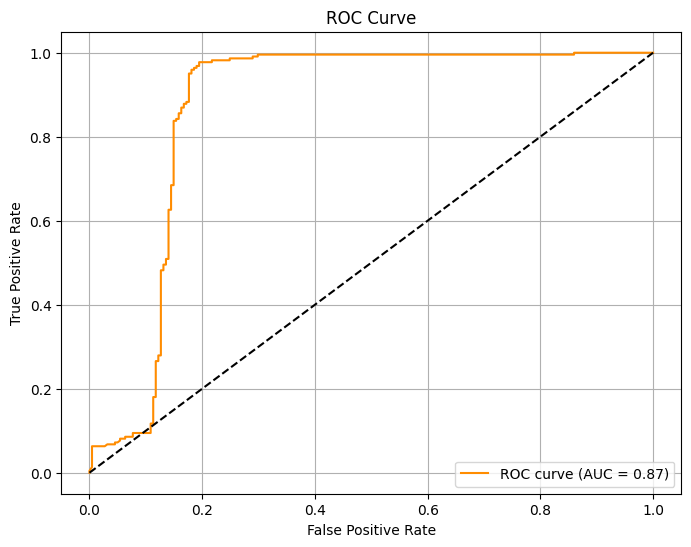

In [ ]:
# Get predicted probabilities for the positive class (assuming class 1 is positive)
y_pred_probs = model.predict(X_test)[:, 1]

# Convert y_test to binary format (assuming class 1 is positive)
y_test_binary = y_test[:, 1]  # Select the column corresponding to the positive class

# Now calculate the ROC curve
fpr, tpr, _ = roc_curve(y_test_binary, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})', color='darkorange')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show();



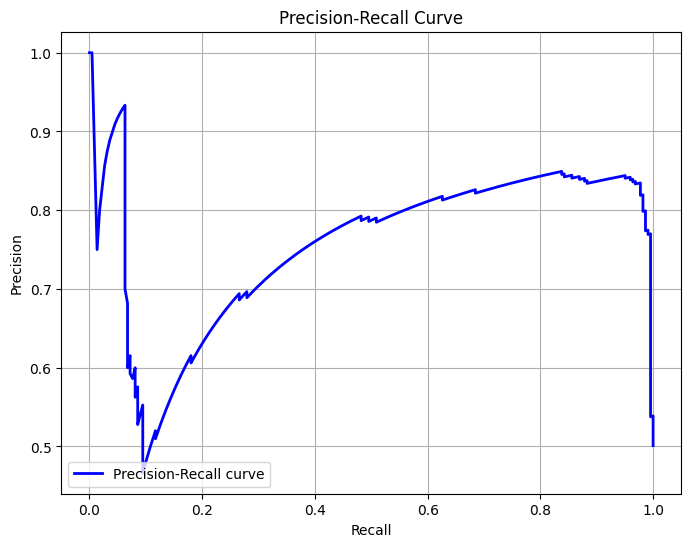

In [ ]:
precision, recall, _ = precision_recall_curve(y_test[:, 1], y_pred_probs)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Precision-Recall curve', color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show();

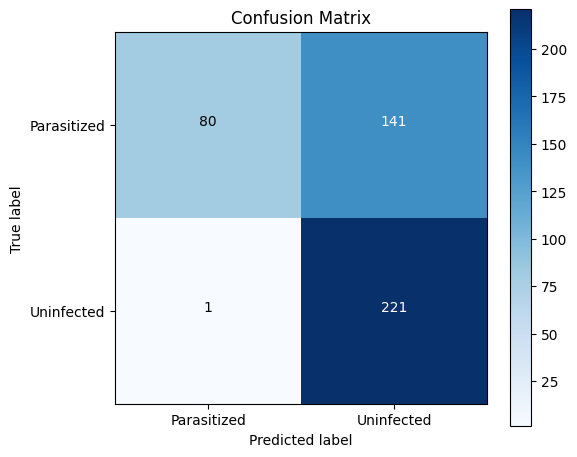

In [ ]:
y_pred = (y_pred_probs > 0.5).astype(int)
# Convert y_test to binary format (assuming class 1 is positive)
y_test_binary = np.argmax(y_test, axis=1)  # Get class labels from one-hot encoded y_test

# Calculate the confusion matrix
from sklearn.metrics import confusion_matrix  # Import confusion_matrix
conf_matrix = confusion_matrix(y_test_binary, y_pred)

plt.figure(figsize=(6, 5))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Parasitized', 'Uninfected'])
plt.yticks(tick_marks, ['Parasitized', 'Uninfected'])

thresh = conf_matrix.max() / 2.
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, format(conf_matrix[i, j], 'd'),
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show();

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# If y_test is one-hot encoded, convert it to scalar labels
y_test_scalar = np.argmax(y_test, axis=1)  # Convert one-hot to scalar (0 or 1)

# If y_pred is in probability format (e.g., output of sigmoid), convert it to binary (0 or 1)
y_pred_binary = (y_pred > 0.5).astype(int)  # Use 0.5 as the threshold for classification

# Now print the classification report
print("Classification Report:")
print(classification_report(y_test_scalar, y_pred_binary))

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.36      0.53       221
           1       0.61      1.00      0.76       222

    accuracy                           0.68       443
   macro avg       0.80      0.68      0.64       443
weighted avg       0.80      0.68      0.64       443



## Model Saving


In [ ]:
from tensorflow.keras.saving import save_model
save_model(model, 'malaria_model.keras')


In [ ]:
model.save('malaria_detection_model.h5')

In [ ]:
list1 = [1,2,3,4]
list2 = [2,4,5,6]
list3 = [2,6,7,8]
result = list()
result.extend(i for i in list1 if i not in (list2+list3) and i not in result)
result.extend(i for i in list2 if i not in (list1+list3) and i not in result)
result.extend(i for i in list3 if i not in (list1+list2) and i not in result)